# Self-Explaining Neural Networks
---

## Import libraries

In [29]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import json
from types import SimpleNamespace
from importlib import import_module
import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
from models.losses import mse_l1_sparsity, zero_loss
from models.parameterizer import ConvParameterizer
from models.conceptizer import ConvConceptizer
from models.aggregator import SumAggregator
from models.senn import SENN

In [31]:
from datasets.dataloaders import get_dataloader
from utils.plot_utils import show_explainations, show_concepts, plot_lambda_accuracy

# Reproducing MNIST Results

## Configuration

In [32]:
plt.style.use('seaborn-talk')

In [33]:
config_path = Path('config')
config_file = config_path /  "lisa_master_l4_s29.json"
with open(config_file, 'r') as f:
    config = json.load(f)

config = SimpleNamespace(**config)

## Load Test Data

In [34]:
_, _, test_dl = get_dataloader(config)

## Load Trained Model

In [35]:
conceptizer = getattr(import_module("models.conceptizer"), config.conceptizer)(**config.__dict__)
parameterizer = getattr(import_module("models.parameterizer"), config.parameterizer)(**config.__dict__)
aggregator = getattr(import_module("models.aggregator"), config.aggregator)(**config.__dict__)

In [36]:
model = SENN(conceptizer, parameterizer, aggregator)

In [37]:
checkpoint_path = Path('results')
model_file = checkpoint_path / config.exp_name / "checkpoints" / "best_model.pt" 
print(f"Loading trained model: {model_file}")
checkpoint = torch.load(model_file, config.device)
print('done.')

Loading trained model: results\lisa_master_l4_s29\checkpoints\best_model.pt
done.


In [38]:
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

## Test Performance

In [39]:
get_nll_Loss = nn.NLLLoss
get_sparsity_loss = mse_l1_sparsity

In [40]:
accuracy = []
model.to(config.device)
model.eval()
with torch.no_grad():
    for i, (x, labels) in enumerate(test_dl):
        x = x.float().to(config.device)
        labels = labels.long().to(config.device)
        y_pred, (concepts, relevances), _ = model(x)
        accuracy.append((y_pred.argmax(axis=1) == labels).float().mean().item())
print(f"Test Mean Accuracy: {sum(accuracy)/len(accuracy):.3f} %")

Test Mean Accuracy: 0.989 %


## Result Visualization

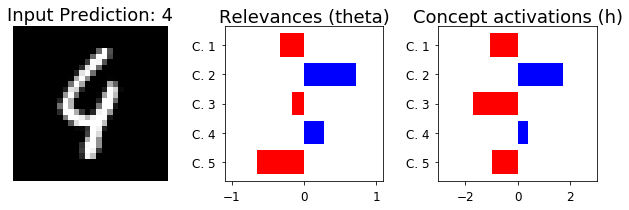

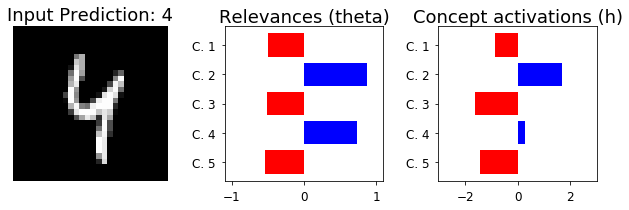

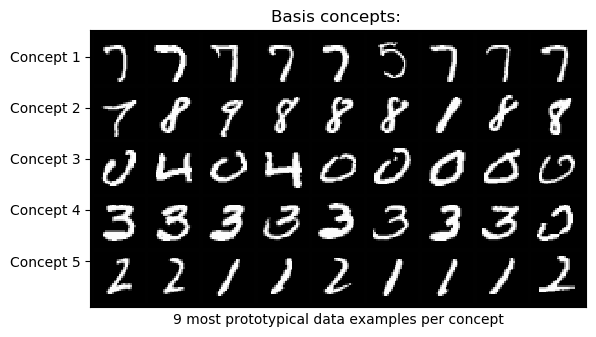

<Figure size 640x480 with 0 Axes>

In [41]:
show_explainations(model, test_dl, 'mnist')
show_concepts(model, test_dl, 'activation')

## Accuracy vs. Lambda 

In [42]:
config_list = ["lisa_master_l4_s29.json", "lisa_master_l3_s29.json", "lisa_master_l2_s29.json", "lisa_master_l1_s29.json", "lisa_master_l0_s29.json"]

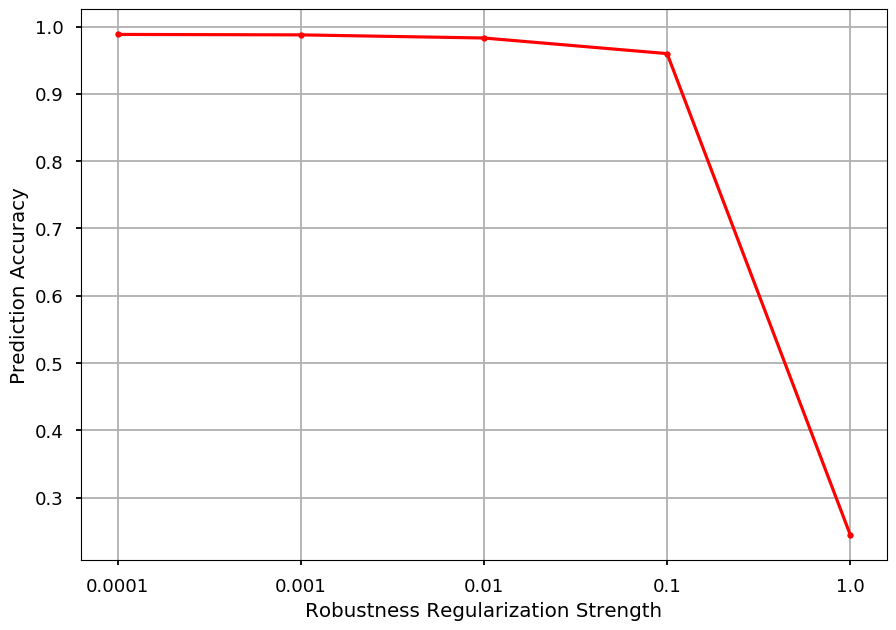

In [43]:
# NOTE: This will read the saved validation accuracies to speed up the process
# in the repoert we evaluate on the test set
_ = plot_lambda_accuracy(config_list, num_seeds=1, valid=True)

## Extension: Alternative Concept Representation

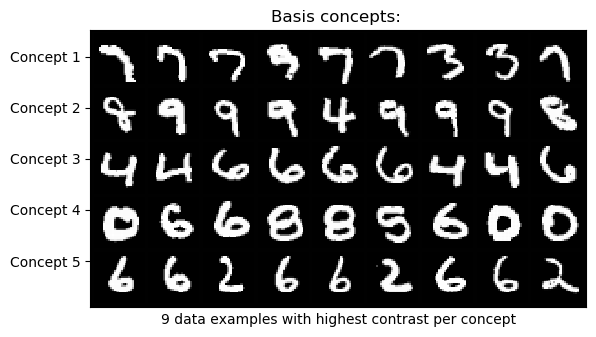

<Figure size 640x480 with 0 Axes>

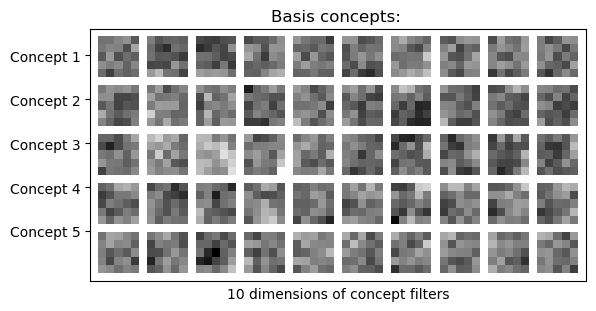

<Figure size 640x480 with 0 Axes>

In [44]:
show_concepts(model, test_dl, 'contrast')
show_concepts(model, test_dl, 'filter')

# Reproducing COMPAS Results

## Configuration

In [45]:
plt.style.use('seaborn-talk')

In [46]:
config_path = Path('config')
config_file = config_path /  "compas_lisa_l4_s29.json"
with open(config_file, 'r') as f:
    config = json.load(f)

config = SimpleNamespace(**config)

## Load Test Data

In [47]:
_, _, test_dl = get_dataloader(config)

Finish preprocessing data..


## Load Trained Model

In [48]:
conceptizer = getattr(import_module("models.conceptizer"), config.conceptizer)(**config.__dict__)
parameterizer = getattr(import_module("models.parameterizer"), config.parameterizer)(**config.__dict__)
aggregator = getattr(import_module("models.aggregator"), config.aggregator)(**config.__dict__)

In [49]:
model = SENN(conceptizer, parameterizer, aggregator)

In [50]:
checkpoint_path = Path('results')
model_file = checkpoint_path / config.exp_name / "checkpoints" / "best_model.pt" 
print(f"Loading trained model: {model_file}")
checkpoint = torch.load(model_file, config.device)
print('done.')

Loading trained model: results\compass_lisa_l4_s29\checkpoints\best_model.pt
done.


In [51]:
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

## Test Performance

In [52]:
get_nll_Loss = nn.NLLLoss
get_sparsity_loss = zero_loss

In [53]:
accuracy = []
model.to(config.device)
model.eval()
with torch.no_grad():
    for i, (x, labels) in enumerate(test_dl):
        x = x.float().to(config.device)
        labels = labels.long().to(config.device)
        y_pred, (concepts, relevances), _ = model(x)
        accuracy.append((y_pred.argmax(axis=1) == labels).float().mean().item())
print(f"Test Mean Accuracy: {sum(accuracy)/len(accuracy):.3f} %")

Test Mean Accuracy: 0.791 %


## Result Visualization

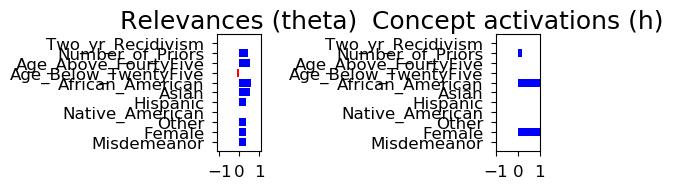

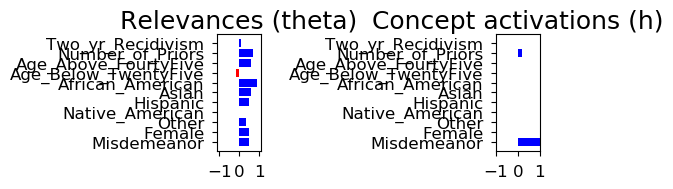

In [54]:
show_explainations(model, test_dl, 'compas', concept_names=config.concept_names)

## Accuracy vs. Lambda 

In [55]:
config_list = [["cl_4_s111.json","cl_4_s333.json","cl_4_s555.json"],
                        ["cl_3_s111.json","cl_3_s333.json","cl_3_s555.json"],
                        ["cl_2_s111.json","cl_2_s333.json","cl_2_s555.json"],
                        ["cl_1_s111.json","cl_1_s333.json","cl_1_s555.json"],
                        ["cl_0_s111.json","cl_0_s333.json","cl_0_s555.json"]]

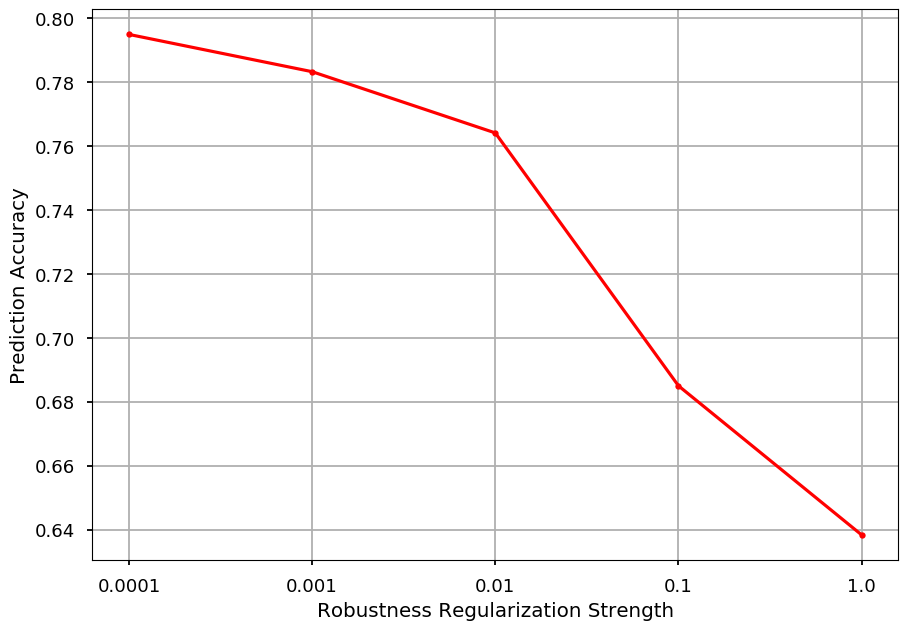

In [56]:
# NOTE: This will read the saved validation accuracies to speed up the process
# in the repoert we evaluate on the test set
_ = plot_lambda_accuracy(config_list, num_seeds=3, valid=True)